In [194]:
import pandas as pd
import copy
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

# Data Exploration

In [195]:
def count_outliers(col):
    Q1 = np.percentile(col, 25, method = 'midpoint')
    Q3 = np.percentile(col, 75, method = 'midpoint')
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    out_abs = sum((col < lower_limit) | (col > upper_limit))
    out_rel = round(out_abs/len(col),2)
    return out_abs, out_rel

def get_outlier_lists(df):
    res_abs = []
    res_rel = []
    for col in df.columns:        
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):            
            #Q1 = np.percentile(df[col], 25, method = 'midpoint')
            #Q3 = np.percentile(df[col], 75, method = 'midpoint')
            #IQR = Q3 - Q1
            #lower_limit = Q1 - 1.5 * IQR
            #upper_limit = Q3 + 1.5 * IQR
            #out_abs = sum((df[col] < lower_limit) | (df[col] > upper_limit))
            #out_rel = round(out_abs/len(df),2)
            out_abs, out_rel = count_outliers(df[col])
            res_abs.append(out_abs)
            res_rel.append(out_rel)
        else:
            res_abs.append(0)
            res_rel.append(0)
    return res_abs, res_rel

def quality(df):
    """Quality inspection of a DataFrame

        Returns
        -------
        result : DataFrame
            Returns:
                number of rows and columns (formatted)
                datatype of columns
                number of missing values per column (absolute and relative)
                number of unique values per column
                number of outliers per column (0 for non-numeric columns)
        """   
    outlier_abs, outlier_rel = get_outlier_lists(df)
    result = pd.DataFrame(df.dtypes,columns=['type'])
    result['unique'] = pd.DataFrame(df.nunique())
    result['missing_abs'] = pd.DataFrame(df.isna().sum())
    result['missing_rel'] = pd.DataFrame(round(100*df.isna().sum()/len(df),2))
    result['outliers_abs'] = outlier_abs
    result['outliers_rel'] = outlier_rel
    numrows = df.shape[0]
    print("Dataframe has " + f'{numrows:,}' + " rows and " + str(df.shape[1]) + " columns.\n")
    print(str(result[result['missing_abs'] != 0].shape[0]) + " column(s) with missing values.\n")
    print(str(result[result['outliers_abs'] != 0].shape[0]) + " column(s) with outliers.\n")
    
    return result

In [196]:
data_raw_x = pd.read_csv("data/x-increments.csv",skiprows=5)
data_raw_x["origin"] = "x"
data_raw_y = pd.read_csv("data/y-increments.csv",skiprows=5)
data_raw_y["origin"] = "y"
data_raw_z = pd.read_csv("data/z-increments.csv",skiprows=5)
data_raw_z["origin"] = "z"

In [197]:
data_raw = pd.concat([data_raw_x, data_raw_y,data_raw_z], axis=0, ignore_index=True)

In [198]:
quality(data_raw)

Dataframe has 746 rows and 43 columns.

0 column(s) with missing values.

38 column(s) with outliers.



,type,unique,missing_abs,missing_rel,outliers_abs,outliers_rel
ccp_x,float64,712,0,0.0,63,0.08
ccp_y,float64,691,0,0.0,241,0.32
ccp_z,float64,693,0,0.0,129,0.17
ccp_rx,float64,746,0,0.0,24,0.03
ccp_ry,float64,380,0,0.0,0,0.00
ccp_rz,float64,746,0,0.0,24,0.03
tcp_x,float64,491,0,0.0,63,0.08
tcp_y,float64,343,0,0.0,240,0.32
tcp_z,float64,133,0,0.0,296,0.40
tcp_rx,float64,347,0,0.0,24,0.03


## Data Explanation

Coordinates/distances are in mm, angles are in degrees.

The angles reported by our robot seem very inconsistent and we were unable to make much sense of them.

The original data is attached as a csv

In [199]:
data_raw.columns.values

array(['ccp_x', 'ccp_y', 'ccp_z', 'ccp_rx', 'ccp_ry', 'ccp_rz', 'tcp_x',
       'tcp_y', 'tcp_z', 'tcp_rx', 'tcp_ry', 'tcp_rz', 'isp_x', 'isp_y',
       'isp_z', 'isp_rx', 'isp_ry', 'isp_rz', 'fsp_x', 'fsp_y', 'fsp_z',
       'fsp_rx', 'fsp_ry', 'fsp_rz', 'ad_x', 'ad_y', 'ad_z', 'ad_rx',
       'ad_ry', 'ad_rz', 'ed_x', 'ed_y', 'ed_z', 'ed_rx', 'ed_ry',
       'ed_rz', 'os_x', 'os_y', 'os_z', 'os_rx', 'os_ry', 'os_rz',
       'origin'], dtype=object)

| data_column | description |
|----- | -- |
| ccp | initial starting location in robot base coordinates (location where image is taken)|
| tcp | ccp shifted by camera offset (from tool center point) |
| isp | in-socket-point - robot base location when plug is completely inserted in socket |
| fsp | front-of-socket-point - robot base location when plug is directly in front of socket (angles adjusted) |
| ad | actual distance between tcp and fsp |
| ed | camera/client estimate of distance |
| os | offset (ed - ad)|

#### Description of data acquisition:
- Move robot to ccp
    - take image
    - save estimated distance (ed)
    - calculate actual distance: fsp - ccp - camera offset
    - calculate offset (difference between estimate and actual distance)

#### camera offset
x = -82mm
y = 6mm
z = 55.5mm
rx = 0°
ry = 0°
rz = 0°

In [200]:
data_raw.sample(15)

,ccp_x,ccp_y,ccp_z,ccp_rx,ccp_ry,ccp_rz,tcp_x,tcp_y,tcp_z,tcp_rx,...,ed_rx,ed_ry,ed_rz,os_x,os_y,os_z,os_rx,os_ry,os_rz,origin
200,580.969971,30.003403,449.940796,21.997437,-179.996597,21.997065,499.0000,36.00000,505.4000,22.000000,...,0.870896,5.872817,2.142862,-14.0000,15.00000,14.4000,-155.800000,-344.800000,-154.700000,x
447,639.945679,54.084332,449.826904,13.966084,-179.976471,13.946723,557.9000,60.10000,505.3000,14.000000,...,0.888085,7.139054,2.446530,-12.8000,14.30000,11.1000,-163.800000,-343.500000,-162.500000,y
737,649.944500,29.998490,521.827000,2.370237,-179.980000,2.368932,567.9445,35.99849,577.3270,2.370237,...,1.512609,8.496964,5.872817,-14.6355,13.42849,12.6370,-174.817154,-342.163036,-170.608251,z
662,649.915700,29.998060,446.816300,2.225097,-179.979000,2.223766,567.9157,35.99806,502.3163,2.225097,...,0.739116,6.508801,1.334992,-10.7643,13.82806,12.3263,-175.735787,-344.150199,-175.291242,z
191,571.973999,30.004450,449.944122,25.048563,-179.996979,25.047903,490.0000,36.00000,505.4000,25.000000,...,0.933921,5.838440,2.446530,-14.7000,15.20000,14.7000,-152.700000,-344.800000,-151.400000,x
530,640.017212,-28.915476,449.909546,19.525225,-179.982178,19.505625,558.0000,-22.90000,505.4000,19.500000,...,0.550039,6.382750,-2.910626,-13.4000,13.70000,10.9000,-158.600000,-344.300000,-162.300000,y
8,388.962647,29.993370,449.949463,16.839619,-179.995285,16.841131,307.0000,36.00000,505.4000,16.800000,...,0.985487,5.563420,1.684496,-21.6000,18.40000,19.9000,-160.900000,-345.100000,-160.300000,x
511,639.991150,-9.916902,449.862549,14.927269,-179.978958,14.908633,558.0000,-3.90000,505.4000,14.900000,...,0.635983,6.440046,-2.005352,-12.7000,13.60000,10.9000,-163.100000,-344.200000,-165.900000,y
151,531.960510,30.004114,449.918152,15.626690,-179.994827,15.626044,450.0000,36.00000,505.4000,15.600000,...,1.002676,5.729578,2.578310,-16.3000,15.80000,15.6000,-162.100000,-344.900000,-160.600000,x
557,640.016174,-55.918293,449.892242,18.104021,-179.981049,18.084774,558.0000,-49.90000,505.4000,18.100000,...,0.481285,7.574502,-2.326209,-15.5000,13.50000,10.7000,-160.100000,-343.100000,-163.100000,y


In [201]:
ad_names = [name for name in data_raw.columns.values if name.startswith("ad")]
ed_names = [name for name in data_raw.columns.values if name.startswith("ed")]
os_names = [name for name in data_raw.columns.values if name.startswith("os")]

### Add rotational offset

In [202]:
%%script false --no-raise-error
# Define the range of values for rs_x, rs_y, and rs_z
rs_x_values = np.linspace(-2.5, 2.5, num=25)  # Adjust num and range as needed
rs_y_values = np.linspace(-2.5, 2.5, num=25)
rs_z_values = np.linspace(-2.5, 2.5, num=25)

total_dict = {}

for rs_x in rs_x_values:
    for rs_y in rs_y_values:
        for rs_z in rs_z_values:

            # Rotation angles in radians
            data_rot = data_raw.copy()

            theta_x = rs_x * (np.pi / 180)  # X-axis rotation
            theta_y = rs_y * (np.pi / 180)  # Y-axis rotation
            theta_z = rs_z * (np.pi / 180)  # Z-axis rotation

            # Rotation matrices for each axis
            rotation_x = np.array([
                [1, 0, 0],
                [0, np.cos(theta_x), -np.sin(theta_x)],
                [0, np.sin(theta_x), np.cos(theta_x)]
            ])

            rotation_y = np.array([
                [np.cos(theta_y), 0, np.sin(theta_y)],
                [0, 1, 0],
                [-np.sin(theta_y), 0, np.cos(theta_y)]
            ])

            rotation_z = np.array([
                [np.cos(theta_z), -np.sin(theta_z), 0],
                [np.sin(theta_z), np.cos(theta_z), 0],
                [0, 0, 1]
            ])
            total_rotation_matrix = np.dot(rotation_z, np.dot(rotation_y, rotation_x))

            ed_values = data_rot[["ed_x", "ed_y", "ed_z"]].values.T
            rotated_values = np.dot(rotation_z, np.dot(rotation_y, np.dot(rotation_x, ed_values)))
            # Update the DataFrame with the rotated values
            data_rot["ed_x"], data_rot["ed_y"], data_rot["ed_z"] = rotated_values

            data_rot["os_x"] = data_rot["ed_x"] - data_rot["ad_x"]
            data_rot["os_y"] = data_rot["ed_y"] - data_rot["ad_y"]
            data_rot["os_z"] = data_rot["ed_z"] - data_rot["ad_z"]

            diff_names = ["origin"] + ad_names + ed_names + os_names

            diff_df = data_rot.loc[:,diff_names]

            DEGREE = 1  # Degree of the polynomial features

            i = 0
            coeff_dict = {}
            for y,x in zip(ad_names,ed_names):
                X = diff_df[x].values.reshape(-1, 1)  # Predictor variable
                Y = diff_df[y]  # Response variable
                
                # Generate polynomial features
                poly_features = PolynomialFeatures(degree=DEGREE)
                X_poly = poly_features.fit_transform(X)
                
                # Perform polynomial regression using statsmodels
                sm_model = sm.OLS(Y, X_poly)
                sm_results = sm_model.fit()
                coeffs = sm_results.params
                if i <= 2:
                    coeff_dict[x] = coeffs.mean()
                i+=1
            total_dict[(rs_x, rs_y, rs_z)] = coeff_dict.values()

# Find the best combination of rs_x, rs_y, and rs_z based on your criteria
# Find the best combination of rs_x, rs_y, and rs_z based on your criteria
best_rotation_angles = min(total_dict, key=lambda k: sum(abs(coeff) for coeff in total_dict[k]))  

# Get the best coefficients
best_coeffs = list(total_dict[best_rotation_angles])

print("Best Rotation Angles (rs_x, rs_y, rs_z):", best_rotation_angles)
print("Best Coefficients:", best_coeffs)

# Rotation angles in radians
rs_x = best_coeffs[0]
rs_y = best_coeffs[1]
rs_z = best_coeffs[2]
theta_x = rs_x * (np.pi / 180)  # X-axis rotation
theta_y = rs_y * (np.pi / 180)  # Y-axis rotation
theta_z = rs_z * (np.pi / 180)  # Z-axis rotation

# Rotation matrices for each axis
rotation_x = np.array([
    [1, 0, 0],
    [0, np.cos(theta_x), -np.sin(theta_x)],
    [0, np.sin(theta_x), np.cos(theta_x)]
])

rotation_y = np.array([
    [np.cos(theta_y), 0, np.sin(theta_y)],
    [0, 1, 0],
    [-np.sin(theta_y), 0, np.cos(theta_y)]
])

rotation_z = np.array([
    [np.cos(theta_z), -np.sin(theta_z), 0],
    [np.sin(theta_z), np.cos(theta_z), 0],
    [0, 0, 1]
])
total_rotation_matrix = np.dot(rotation_z, np.dot(rotation_y, rotation_x))

ed_values = data_raw[["ed_x", "ed_y", "ed_z"]].values.T
rotated_values = np.dot(rotation_z, np.dot(rotation_y, np.dot(rotation_x, ed_values)))
# Update the DataFrame with the rotated values
data_raw["ed_x"], data_raw["ed_y"], data_raw["ed_z"] = rotated_values

data_raw["os_x"] = data_raw["ed_x"] - data_raw["ad_x"]
data_raw["os_y"] = data_raw["ed_y"] - data_raw["ad_y"]
data_raw["os_z"] = data_raw["ed_z"] - data_raw["ad_z"]


Couldn't find program: 'false'


In [203]:
diff_names = ["origin"] + ad_names + ed_names + os_names

diff_df = data_raw.loc[:,diff_names]
diff_df

,origin,ad_x,ad_y,ad_z,ad_rx,ad_ry,ad_rz,ed_x,ed_y,ed_z,ed_rx,ed_ry,ed_rz,os_x,os_y,os_z,os_rx,os_ry,os_rz
0,x,807.5000,-53.10000,11.1000,163.000000,350.70,163.100000,784.9,-34.6,31.5,1.025594,5.448829,1.913679,-22.6000,18.50000,20.4000,-162.000000,-345.200000,-161.200000
1,x,806.5000,-53.10000,11.1000,161.800000,350.70,162.000000,784.2,-34.6,31.4,0.825059,6.336913,-0.229183,-22.3000,18.50000,20.3000,-161.000000,-344.300000,-162.200000
2,x,805.5000,-53.10000,11.2000,163.900000,350.70,164.100000,782.9,-34.6,31.5,0.985487,6.273888,1.822006,-22.6000,18.50000,20.3000,-162.900000,-344.400000,-162.300000
3,x,804.5000,-53.10000,11.1000,160.200000,350.70,160.300000,782.8,-34.6,31.4,0.893814,5.276941,1.191752,-21.7000,18.50000,20.3000,-159.300000,-345.400000,-159.100000
4,x,803.5000,-53.10000,11.2000,167.300000,350.70,167.400000,781.3,-34.6,31.4,0.905273,4.847223,2.068378,-22.2000,18.50000,20.2000,-166.400000,-345.800000,-165.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,z,538.5353,-53.12846,-64.7383,176.310279,350.66,176.461577,523.3,-39.7,-51.8,1.564175,8.548530,6.016057,-15.2353,13.42846,12.9383,-174.746104,-342.111470,-170.445520
742,z,538.5351,-53.12845,-65.7323,176.344932,350.66,176.496228,523.4,-39.7,-52.8,1.587093,8.943871,6.021786,-15.1351,13.42845,12.9323,-174.757839,-341.716129,-170.474442
743,z,538.5333,-53.12842,-66.7398,176.264358,350.66,176.415652,522.2,-39.6,-53.6,1.764710,9.104299,6.852575,-16.3333,13.52842,13.1398,-174.499648,-341.555701,-169.563077
744,z,538.5338,-53.12842,-67.7393,176.295621,350.66,176.446913,522.6,-39.7,-54.6,1.678766,8.582908,6.726525,-15.9338,13.42842,13.1393,-174.616855,-342.077092,-169.720388


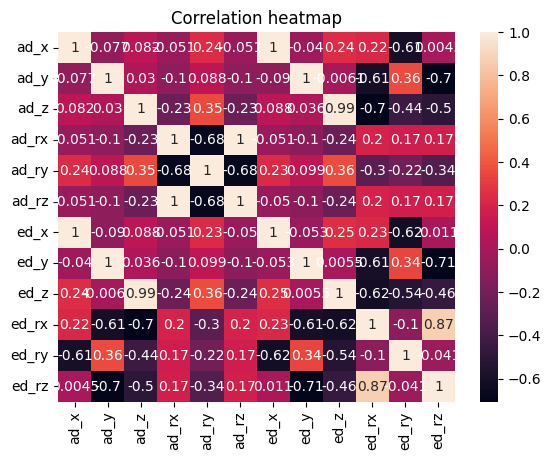

In [204]:
sns.heatmap(diff_df.iloc[:,1:13].corr(),annot=True).set_title("Correlation heatmap")
plt.show()

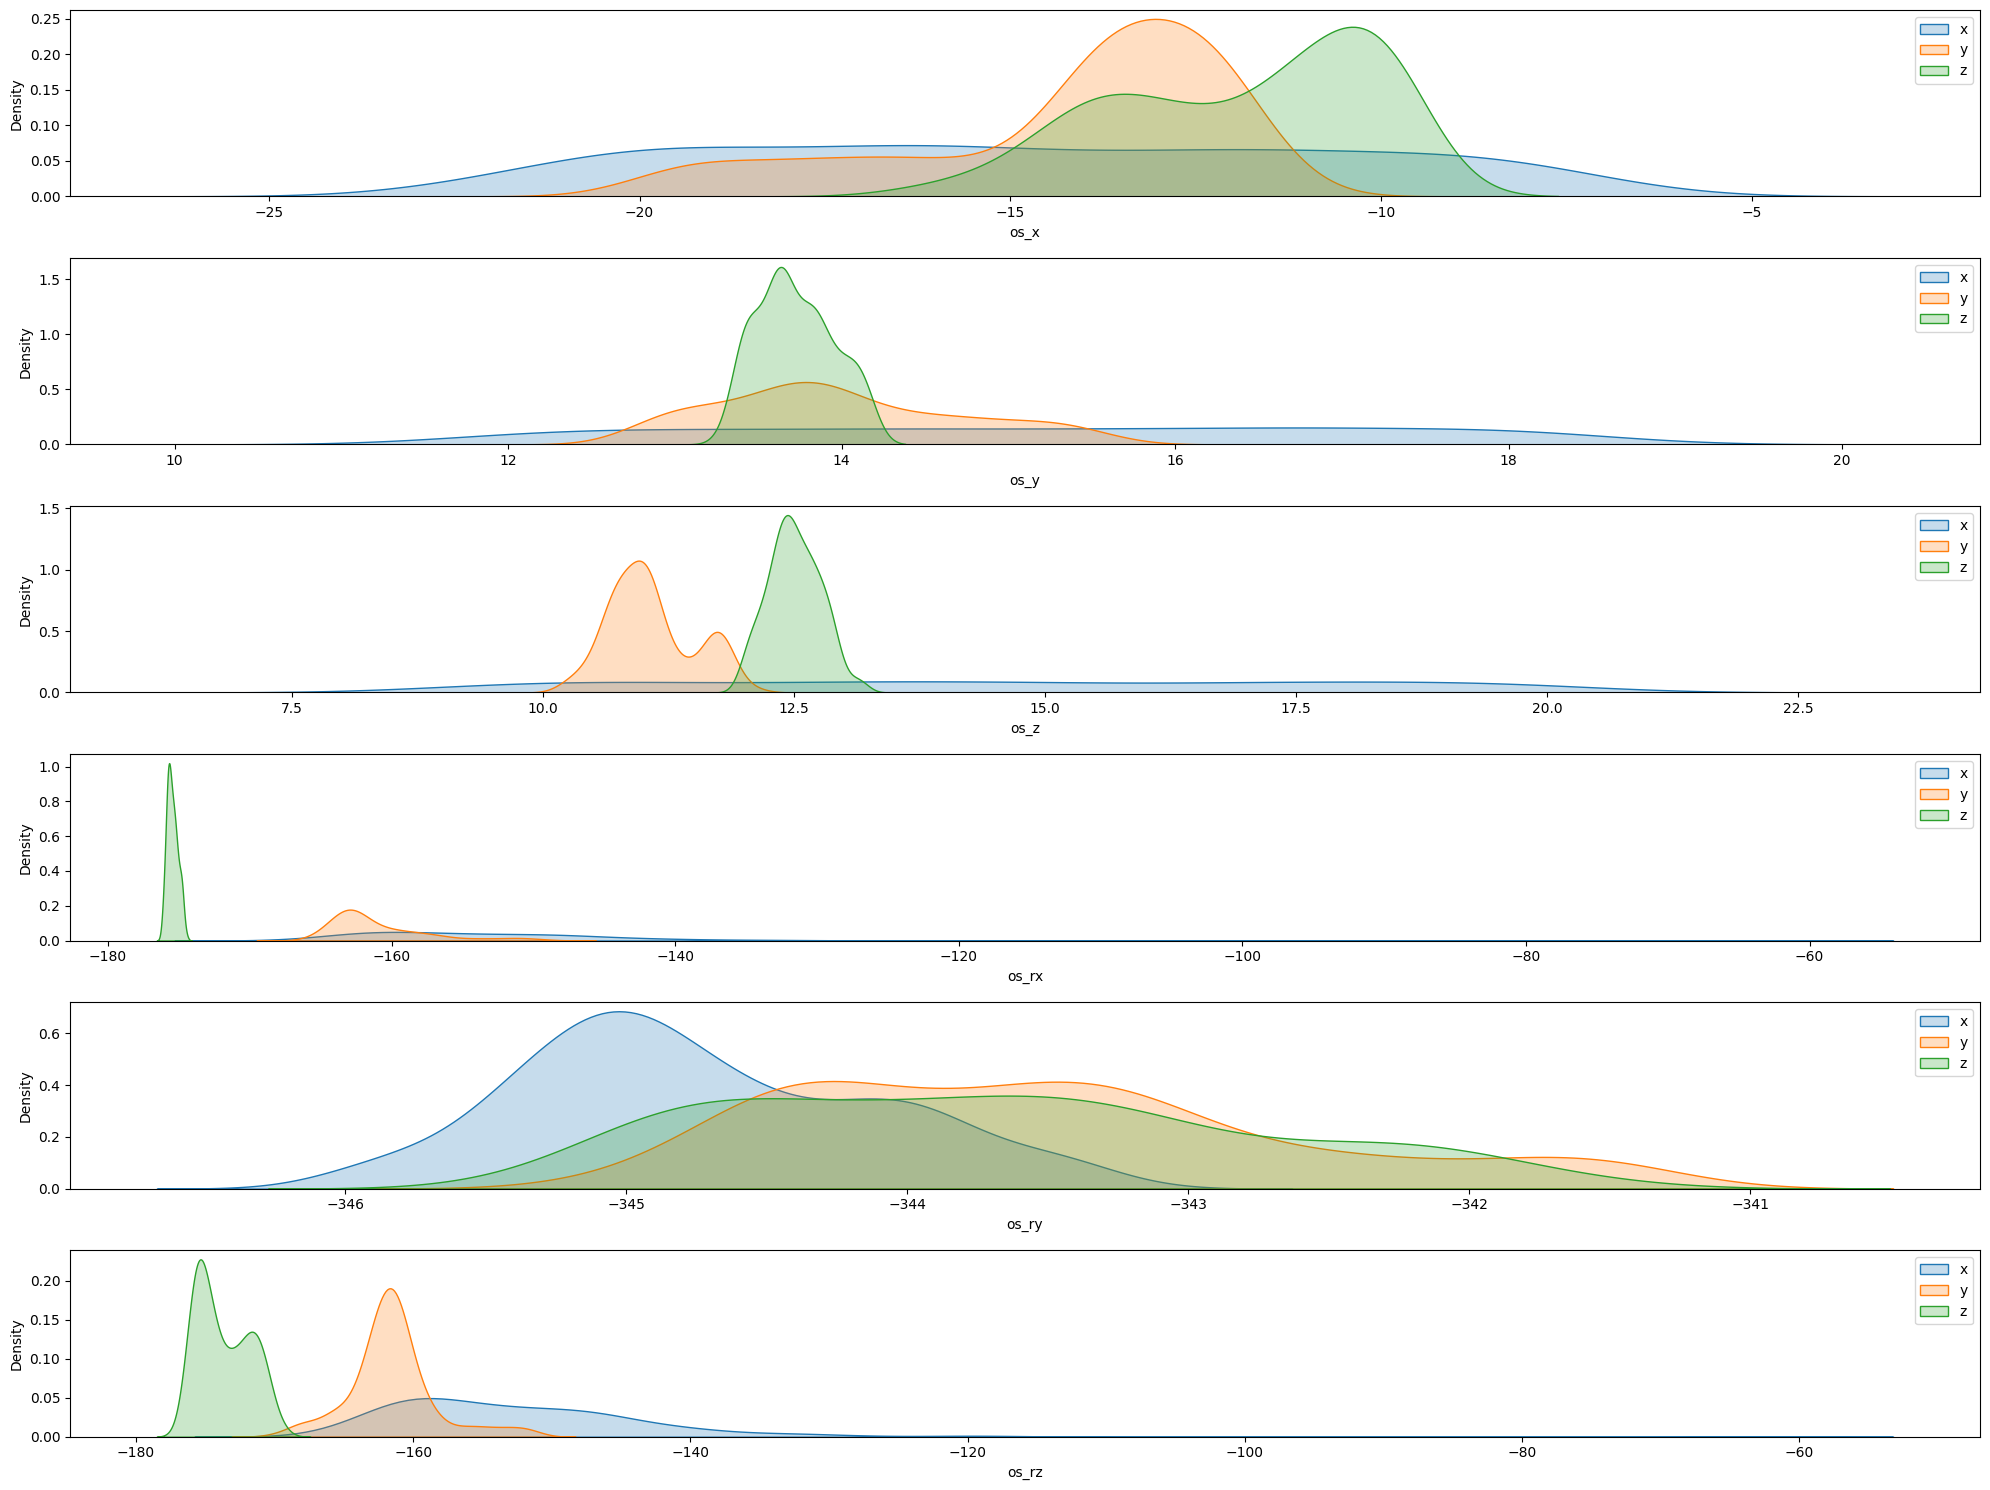

In [205]:
fig,axs = plt.subplots(nrows=len(os_names),ncols=1,figsize=[20,15])

for i,name in enumerate(os_names):
    for origin in diff_df["origin"].unique():
        ax = axs[i]
        df_subset = diff_df.loc[:,name].loc[diff_df["origin"]==origin]
        sns.kdeplot(df_subset,ax=ax,label=origin,fill=True,palette="tab20")
        ax.legend()
plt.tight_layout()
plt.show()

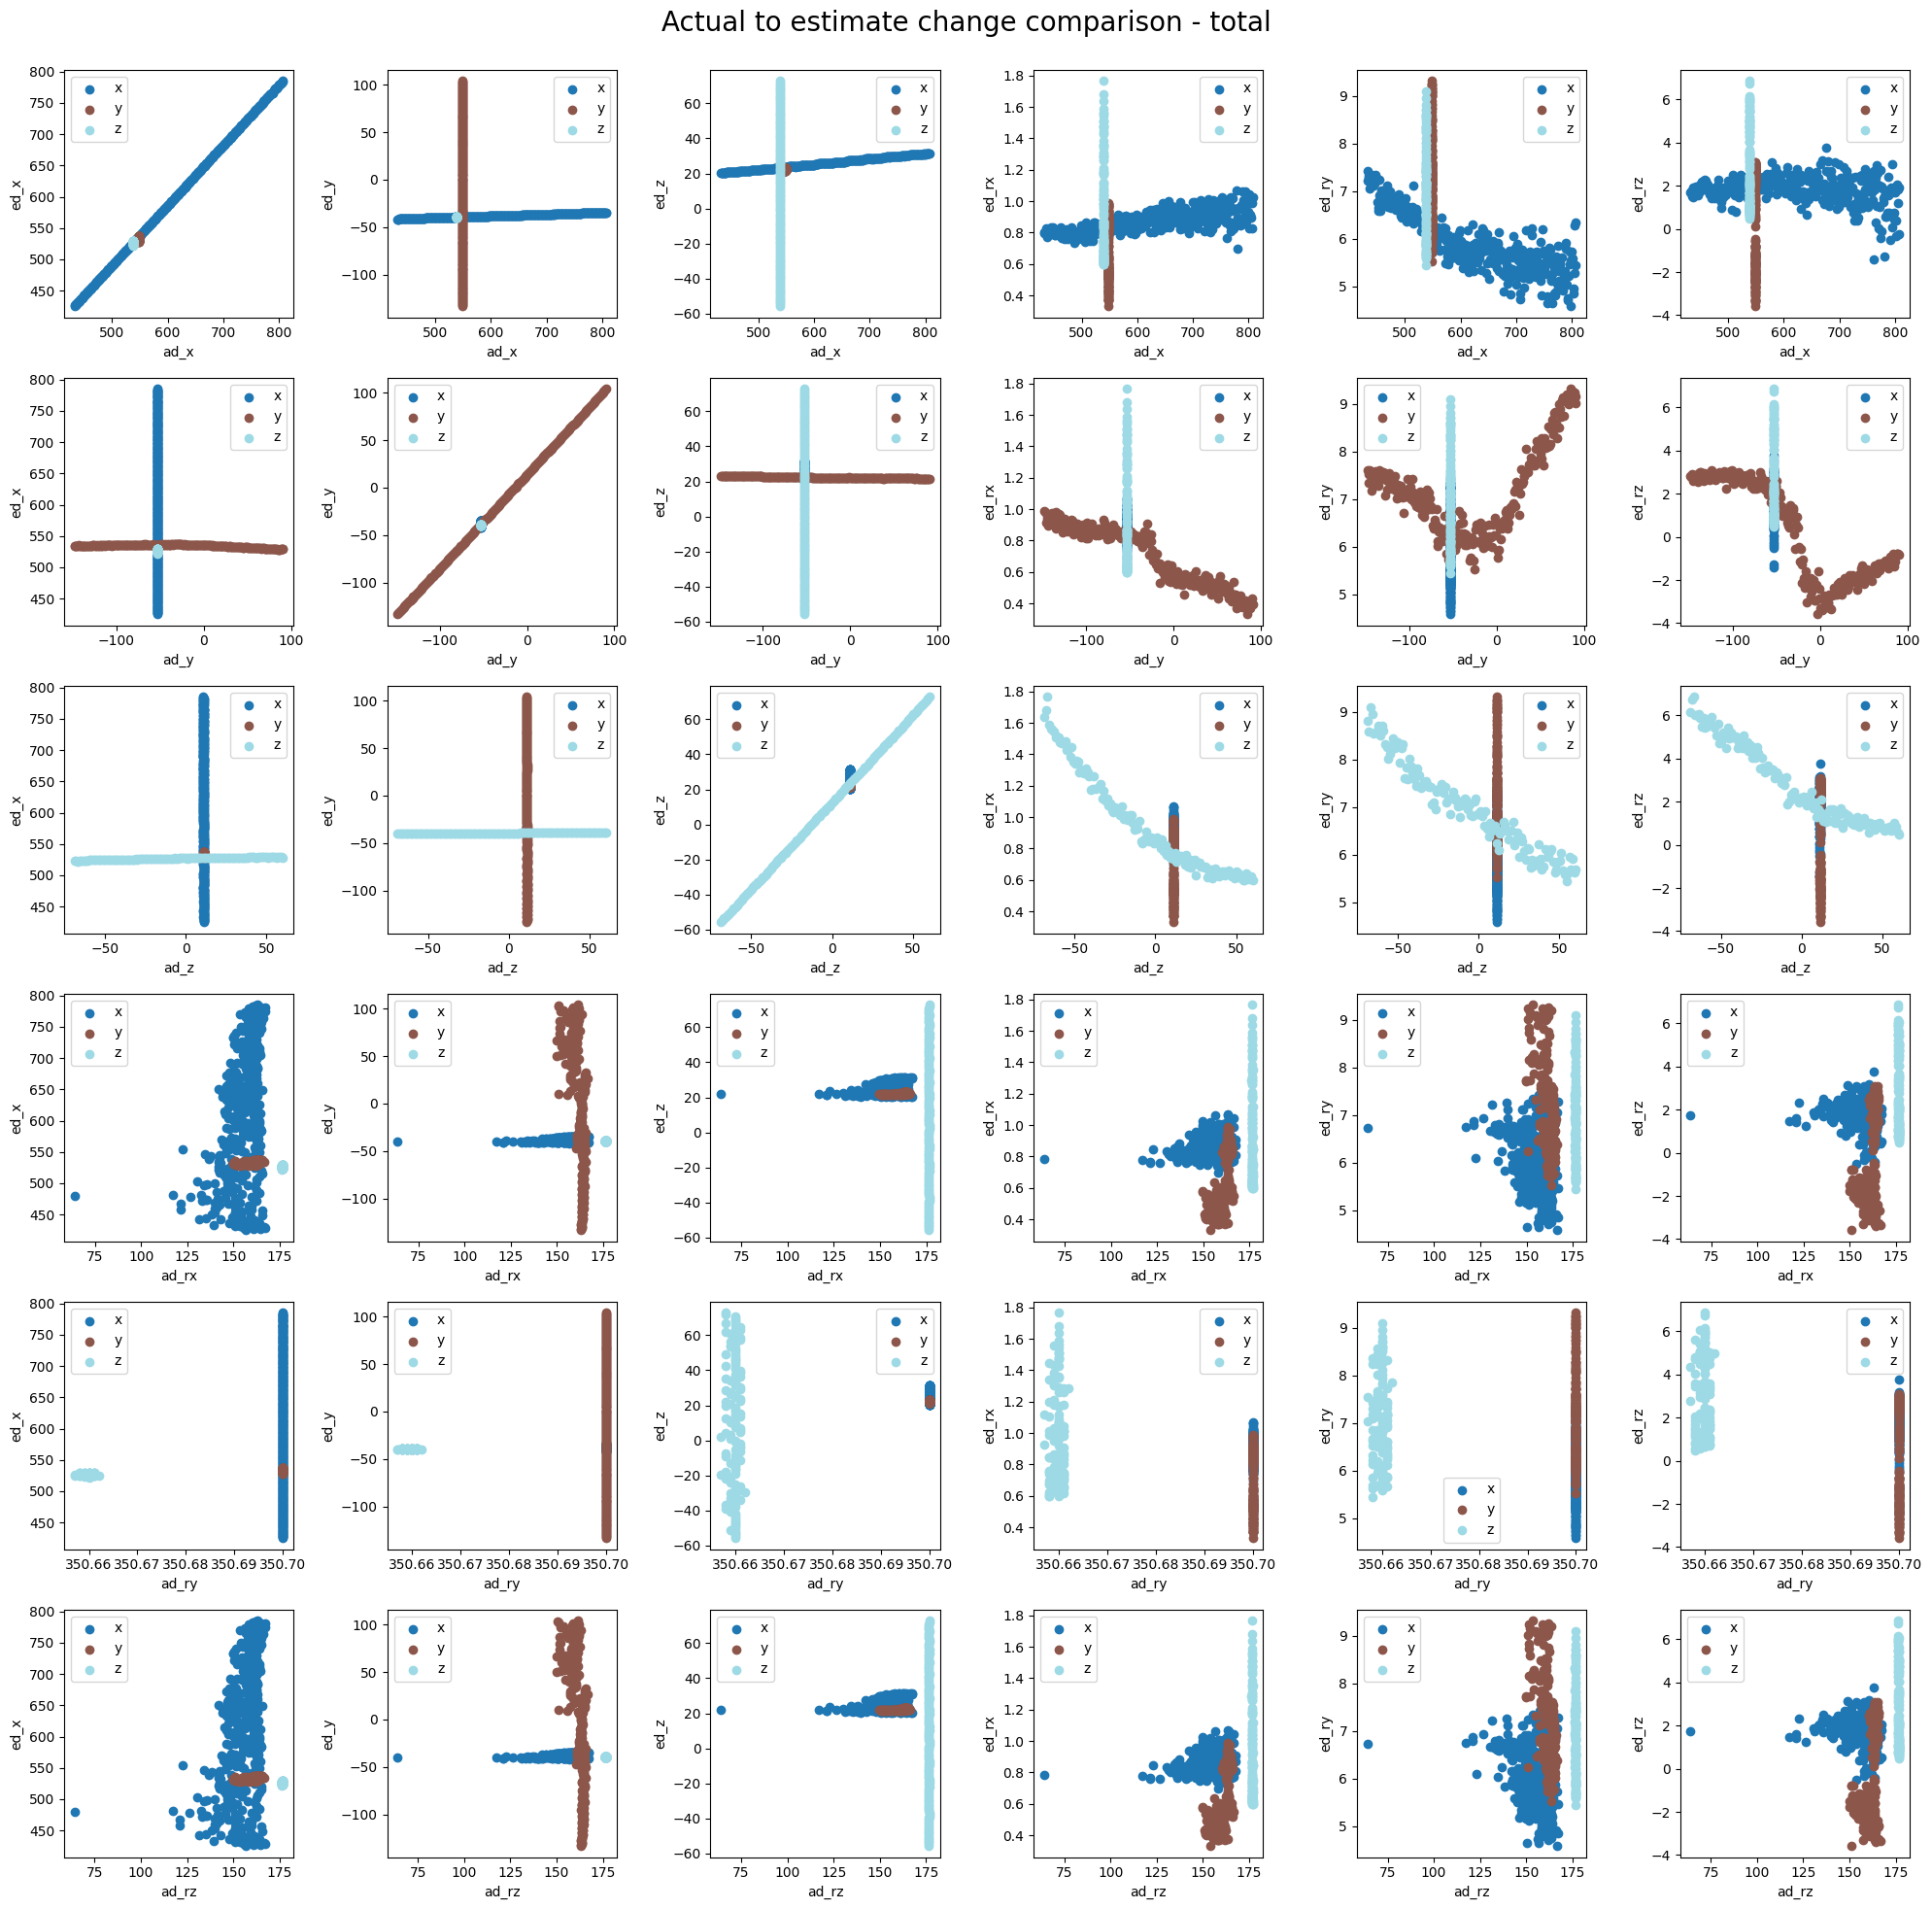

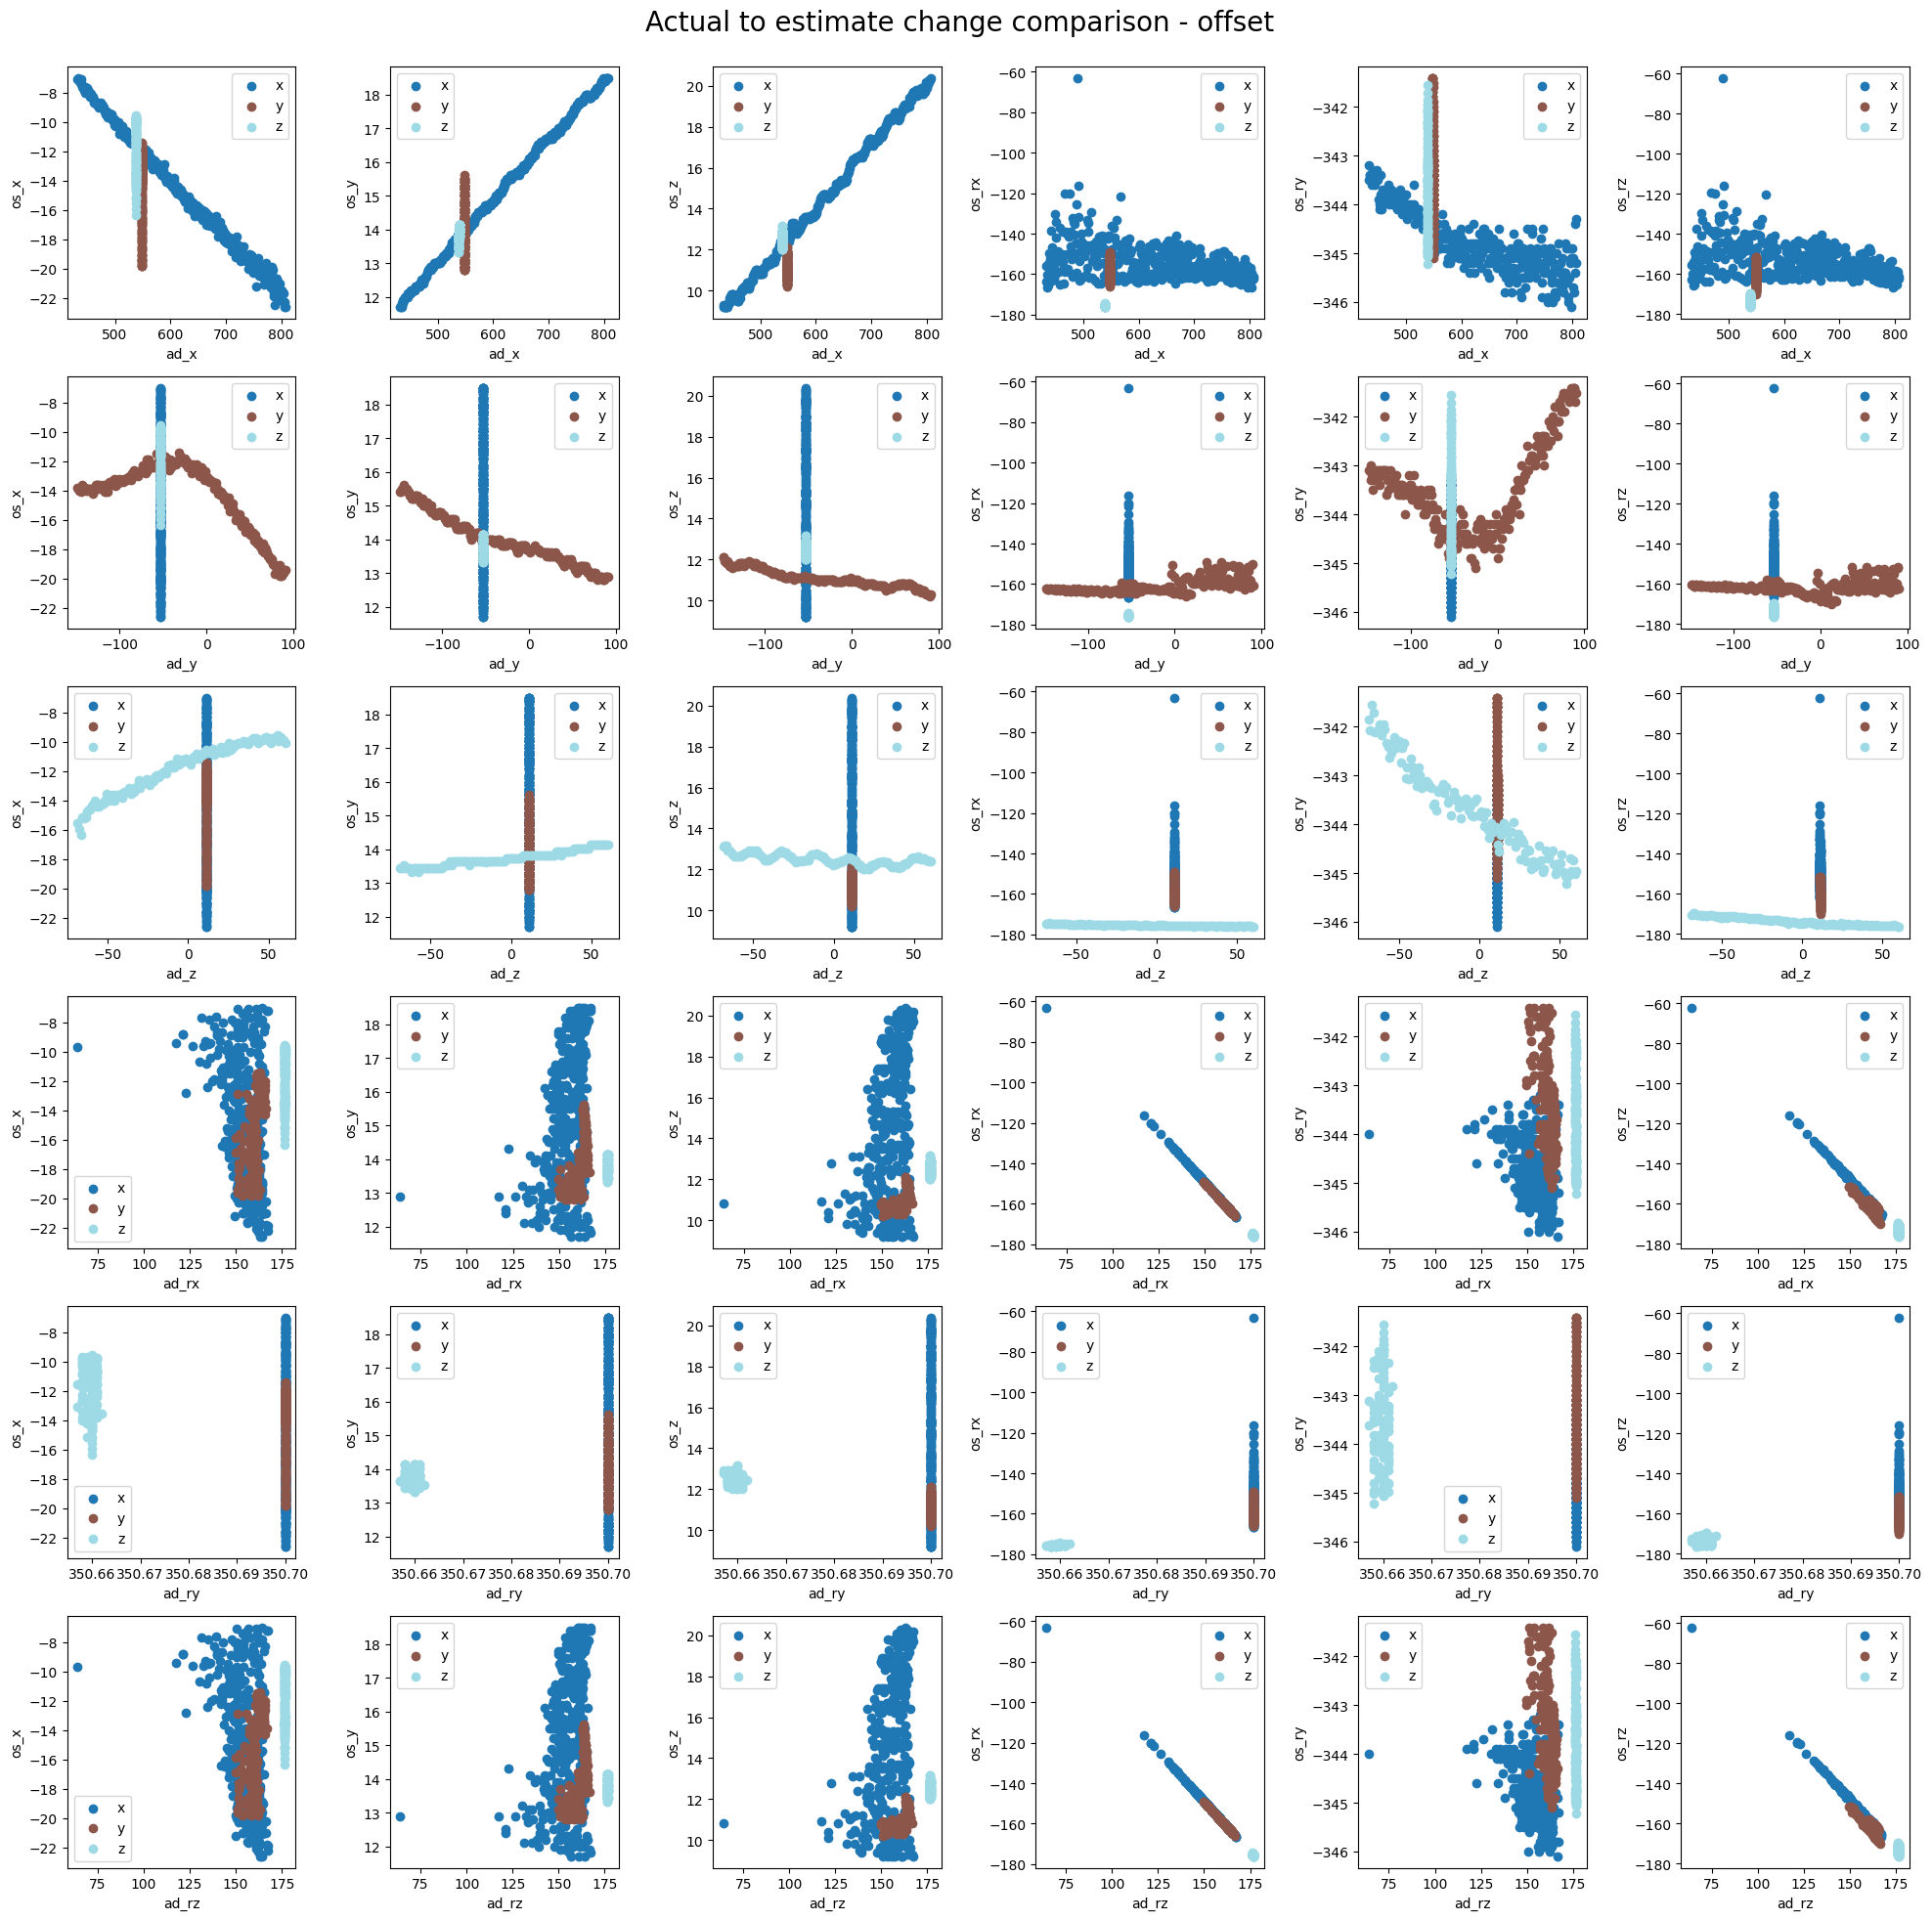

In [216]:
# show scatterplots
def show_scatter(df, title, first_names:list=ad_names, second_names:list=ed_names, split=True):
    unique_origins = df["origin"].unique()
    num_origins = len(unique_origins)
    colormap = plt.cm.get_cmap("tab20", num_origins)

    fig, axs = plt.subplots(len(first_names), len(second_names), figsize=(20, 20))
    for i, x in enumerate(first_names):
        for j, y in enumerate(second_names):
            for k, origin in enumerate(unique_origins):
                if split:
                    subset_df = df[df["origin"] == origin]
                else:
                    subset_df = df
                axs[i, j].scatter(subset_df[x], subset_df[y], color=colormap(k), label=origin)
            if split:
                axs[i, j].legend()  # Show legend for each subplot
            axs[i, j].set_xlabel(x)  # Add x-axis legend
            axs[i, j].set_ylabel(y)  # Add y-axis legend
            
    plt.suptitle(f"Actual to estimate change comparison - {title}", fontsize=20)
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

show_scatter(diff_df, "total")
show_scatter(diff_df, "offset",ad_names, os_names)

In [207]:
data_raw.loc[:,os_names].describe()

,os_x,os_y,os_z,os_rx,os_ry,os_rz
count,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,-14.077674,14.561870,13.139311,-159.656883,-344.162710,-159.134467
std,3.515752,1.606974,2.875974,10.750754,0.978299,10.624846
min,-22.600000,11.700000,9.200000,-176.126200,-346.100000,-176.362694
25%,-16.575000,13.507105,11.000000,-163.600000,-344.900000,-163.500000
50%,-13.500000,14.000000,12.327150,-160.850000,-344.300000,-160.800000
75%,-11.714750,15.500000,14.700000,-154.050000,-343.516399,-153.725000
max,-7.000000,18.500000,20.400000,-63.000000,-341.400000,-62.200000


## Multiple Linear Regression

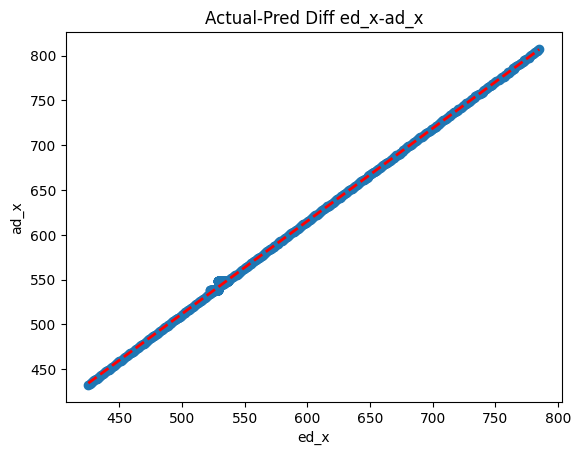

Regression Analysis for ed_x-ad_x:
R_squared:  0.9995380649684862
p-score:  0.0


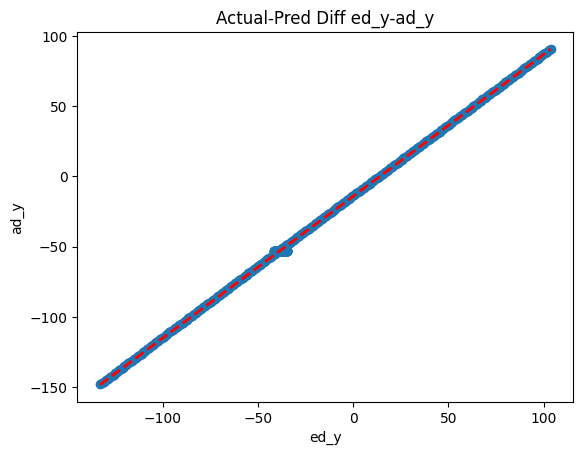

Regression Analysis for ed_y-ad_y:
R_squared:  0.9985752113149181
p-score:  0.0


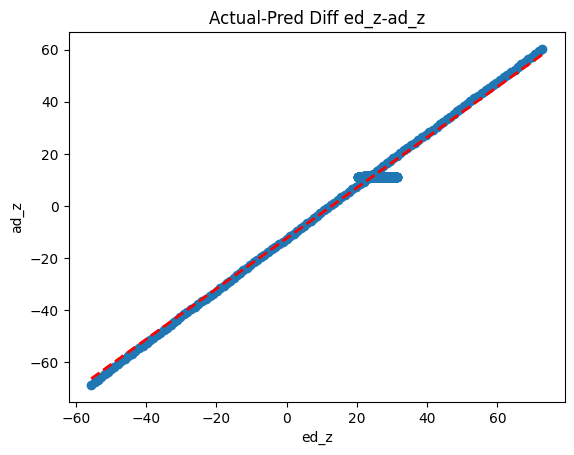

Regression Analysis for ed_z-ad_z:
R_squared:  0.9714051910966087
p-score:  0.0


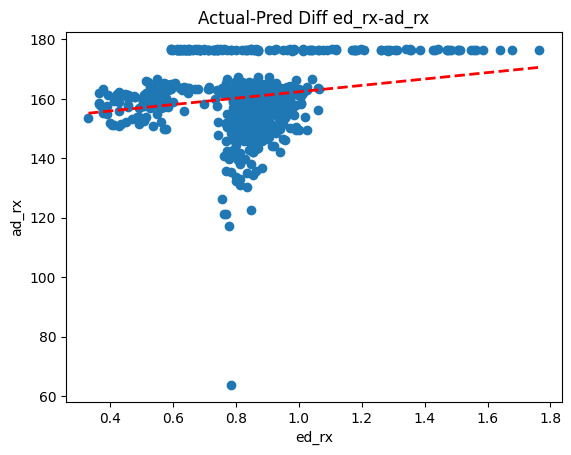

Regression Analysis for ed_rx-ad_rx:
R_squared:  0.039482410242883126
p-score:  4.432237900889597e-08


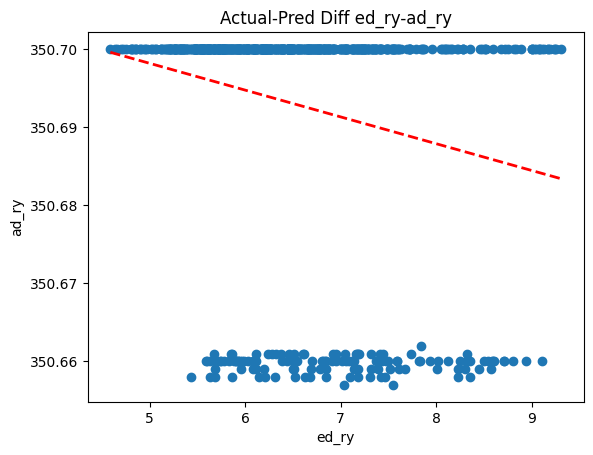

Regression Analysis for ed_ry-ad_ry:
R_squared:  0.04758575388828079
p-score:  1.7359535475773988e-09


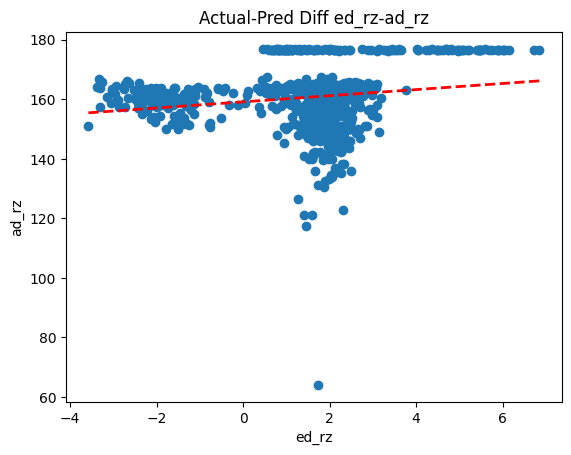

Regression Analysis for ed_rz-ad_rz:
R_squared:  0.030347191984446686
p-score:  1.6953388094481515e-06


In [208]:
DEGREE = 1  # Degree of the polynomial features

coeff_dict = {}
for y,x in zip(ad_names,ed_names):
    X = diff_df[x].values.reshape(-1, 1)  # Predictor variable
    Y = diff_df[y]  # Response variable
    
    # Generate polynomial features
    poly_features = PolynomialFeatures(degree=DEGREE)
    X_poly = poly_features.fit_transform(X)
    
    # Perform polynomial regression using statsmodels
    sm_model = sm.OLS(Y, X_poly)
    sm_results = sm_model.fit()
    coeffs = sm_results.params
    coeff_dict[x] = coeffs
    
    # Predict using the polynomial regression model
    y_pred = sm_results.predict(X_poly)
    
    # Plot the data and the polynomial regression curve
    plt.scatter(X, Y)
    plt.title(f"Actual-Pred Diff {x}-{y}")
    plt.xlabel(x)
    plt.ylabel(y)
    
    # Sort the x values for better visualization
    sorted_indices = np.argsort(X, axis=0)
    x_sorted = X[sorted_indices].reshape(-1, 1)
    y_pred_sorted = y_pred[sorted_indices].reshape(-1, 1)
    
    # Plot the regression line
    plt.plot(x_sorted, y_pred_sorted, '--', color='red', linewidth=2)
    plt.show()
    
    # Print summary of regression analysis
    print(f"Regression Analysis for {x}-{y}:")
    print(f"R_squared: ",sm_results.rsquared)
    print(f"p-score: ",sm_results.f_pvalue)

In [209]:
coeff_dict

{'ed_x': const   -6.478544
 x1       1.036144
 dtype: float64,
 'ed_y': const   -14.228055
 x1        1.010876
 dtype: float64,
 'ed_z': const   -12.484040
 x1        0.969714
 dtype: float64,
 'ed_rx': const    151.545698
 x1        10.763392
 dtype: float64,
 'ed_ry': const    350.715286
 x1        -0.003429
 dtype: float64,
 'ed_rz': const    159.090451
 x1         1.028805
 dtype: float64}

### Calculate actual distance from estimate

In [210]:
def recalc_coordinates(coords, coeffs_raw: dict = coeff_dict):
    coeffs = copy.deepcopy(coeffs_raw)
    new_coords = []
    for i, x in enumerate(ed_names):
        rel_coeffs = coeffs[x]
        rel_coeffs["x0"] = rel_coeffs.pop("const")
        degree = len(rel_coeffs) - 1  # Degree of the polynomial
        new_coord = 0

        for d in range(degree + 1):
            coefficient = rel_coeffs[f'x{d}']
            new_coord += coefficient * coords[i] ** d

        new_coords.append(new_coord)

    return new_coords

In [211]:
sample_size = len(diff_df)
df_test = diff_df.sample(sample_size,ignore_index=True)

ned_names = ['ned_x', 'ned_y', 'ned_z', 'ned_rx', 'ned_ry', 'ned_rz']
new_data = []
for i, row in df_test.iterrows():
    coords = [row[name] for name in ed_names]
    new_coords = recalc_coordinates(coords)
    new_data.append(new_coords)

new_df = pd.DataFrame(new_data, columns=ned_names)
# Concatenate new_df with the original df
result_df = pd.concat([df_test, new_df], axis=1)

nos_names =["nos_x","nos_y","nos_z","nos_rx","nos_ry","nos_rz"]
for name in nos_names:
    ed_col = "ad_" + name.split("_")[1]
    ned_col = "ned_" + name.split("_")[1]
    result_df[name] = result_df[ed_col] - result_df[ned_col]
result_df

,origin,ad_x,ad_y,ad_z,ad_rx,ad_ry,ad_rz,ed_x,ed_y,ed_z,...,ned_z,ned_rx,ned_ry,ned_rz,nos_x,nos_y,nos_z,nos_rx,nos_ry,nos_rz
0,z,538.5643,-53.12759,24.2561,176.256517,350.661,176.407719,527.9,-39.3,36.4,...,22.813540,159.377745,350.693146,160.841152,-1.937809,0.827885,1.442560,16.878772,-0.032146,15.566567
1,y,548.5000,-43.20000,11.2000,162.100000,350.700,162.300000,535.9,-29.2,22.2,...,9.043605,160.487804,350.692144,160.074852,-0.291264,0.545629,2.156395,1.612196,0.007856,2.225148
2,z,538.5509,-53.12886,-33.7248,176.483604,350.659,176.634961,525.1,-39.5,-20.9,...,-32.751057,164.558004,350.689512,163.971194,0.949996,1.028790,-0.973743,11.925600,-0.030512,12.663767
3,x,434.5000,-53.10000,11.2000,161.000000,350.700,161.200000,427.4,-41.4,20.4,...,7.298120,160.179455,350.690199,160.634840,-1.869592,2.978314,3.901880,0.820545,0.009801,0.565160
4,x,674.5000,-53.10000,11.1000,151.100000,350.700,151.300000,657.8,-36.9,27.6,...,14.280059,161.412849,350.696093,161.124093,-0.597272,-1.570627,-3.180059,-10.312849,0.003907,-9.824093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,x,640.5000,-53.10000,11.2000,163.700000,350.700,163.800000,625.0,-37.5,26.3,...,13.019431,160.734482,350.694993,160.823468,-0.611734,-0.964102,-1.819431,2.965518,0.005007,2.976532
742,z,538.5512,-53.12893,-25.7329,176.437374,350.659,176.588746,526.0,-39.6,-13.2,...,-25.284261,162.646242,350.690180,162.739219,0.017766,1.129807,-0.448639,13.791132,-0.031180,13.849527
743,x,644.5000,-53.10000,11.2000,162.100000,350.700,162.200000,628.5,-37.4,26.4,...,13.116403,160.919491,350.694678,160.499264,-0.238240,-1.065189,-1.916403,1.180509,0.005322,1.700736
744,x,543.5000,-53.10000,11.1000,143.100000,350.700,143.200000,531.9,-39.3,23.7,...,10.498175,160.857822,350.694757,161.418824,-1.146686,0.855475,0.601825,-17.757822,0.005243,-18.218824


In [212]:
result_df

,origin,ad_x,ad_y,ad_z,ad_rx,ad_ry,ad_rz,ed_x,ed_y,ed_z,...,ned_z,ned_rx,ned_ry,ned_rz,nos_x,nos_y,nos_z,nos_rx,nos_ry,nos_rz
0,z,538.5643,-53.12759,24.2561,176.256517,350.661,176.407719,527.9,-39.3,36.4,...,22.813540,159.377745,350.693146,160.841152,-1.937809,0.827885,1.442560,16.878772,-0.032146,15.566567
1,y,548.5000,-43.20000,11.2000,162.100000,350.700,162.300000,535.9,-29.2,22.2,...,9.043605,160.487804,350.692144,160.074852,-0.291264,0.545629,2.156395,1.612196,0.007856,2.225148
2,z,538.5509,-53.12886,-33.7248,176.483604,350.659,176.634961,525.1,-39.5,-20.9,...,-32.751057,164.558004,350.689512,163.971194,0.949996,1.028790,-0.973743,11.925600,-0.030512,12.663767
3,x,434.5000,-53.10000,11.2000,161.000000,350.700,161.200000,427.4,-41.4,20.4,...,7.298120,160.179455,350.690199,160.634840,-1.869592,2.978314,3.901880,0.820545,0.009801,0.565160
4,x,674.5000,-53.10000,11.1000,151.100000,350.700,151.300000,657.8,-36.9,27.6,...,14.280059,161.412849,350.696093,161.124093,-0.597272,-1.570627,-3.180059,-10.312849,0.003907,-9.824093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,x,640.5000,-53.10000,11.2000,163.700000,350.700,163.800000,625.0,-37.5,26.3,...,13.019431,160.734482,350.694993,160.823468,-0.611734,-0.964102,-1.819431,2.965518,0.005007,2.976532
742,z,538.5512,-53.12893,-25.7329,176.437374,350.659,176.588746,526.0,-39.6,-13.2,...,-25.284261,162.646242,350.690180,162.739219,0.017766,1.129807,-0.448639,13.791132,-0.031180,13.849527
743,x,644.5000,-53.10000,11.2000,162.100000,350.700,162.200000,628.5,-37.4,26.4,...,13.116403,160.919491,350.694678,160.499264,-0.238240,-1.065189,-1.916403,1.180509,0.005322,1.700736
744,x,543.5000,-53.10000,11.1000,143.100000,350.700,143.200000,531.9,-39.3,23.7,...,10.498175,160.857822,350.694757,161.418824,-1.146686,0.855475,0.601825,-17.757822,0.005243,-18.218824


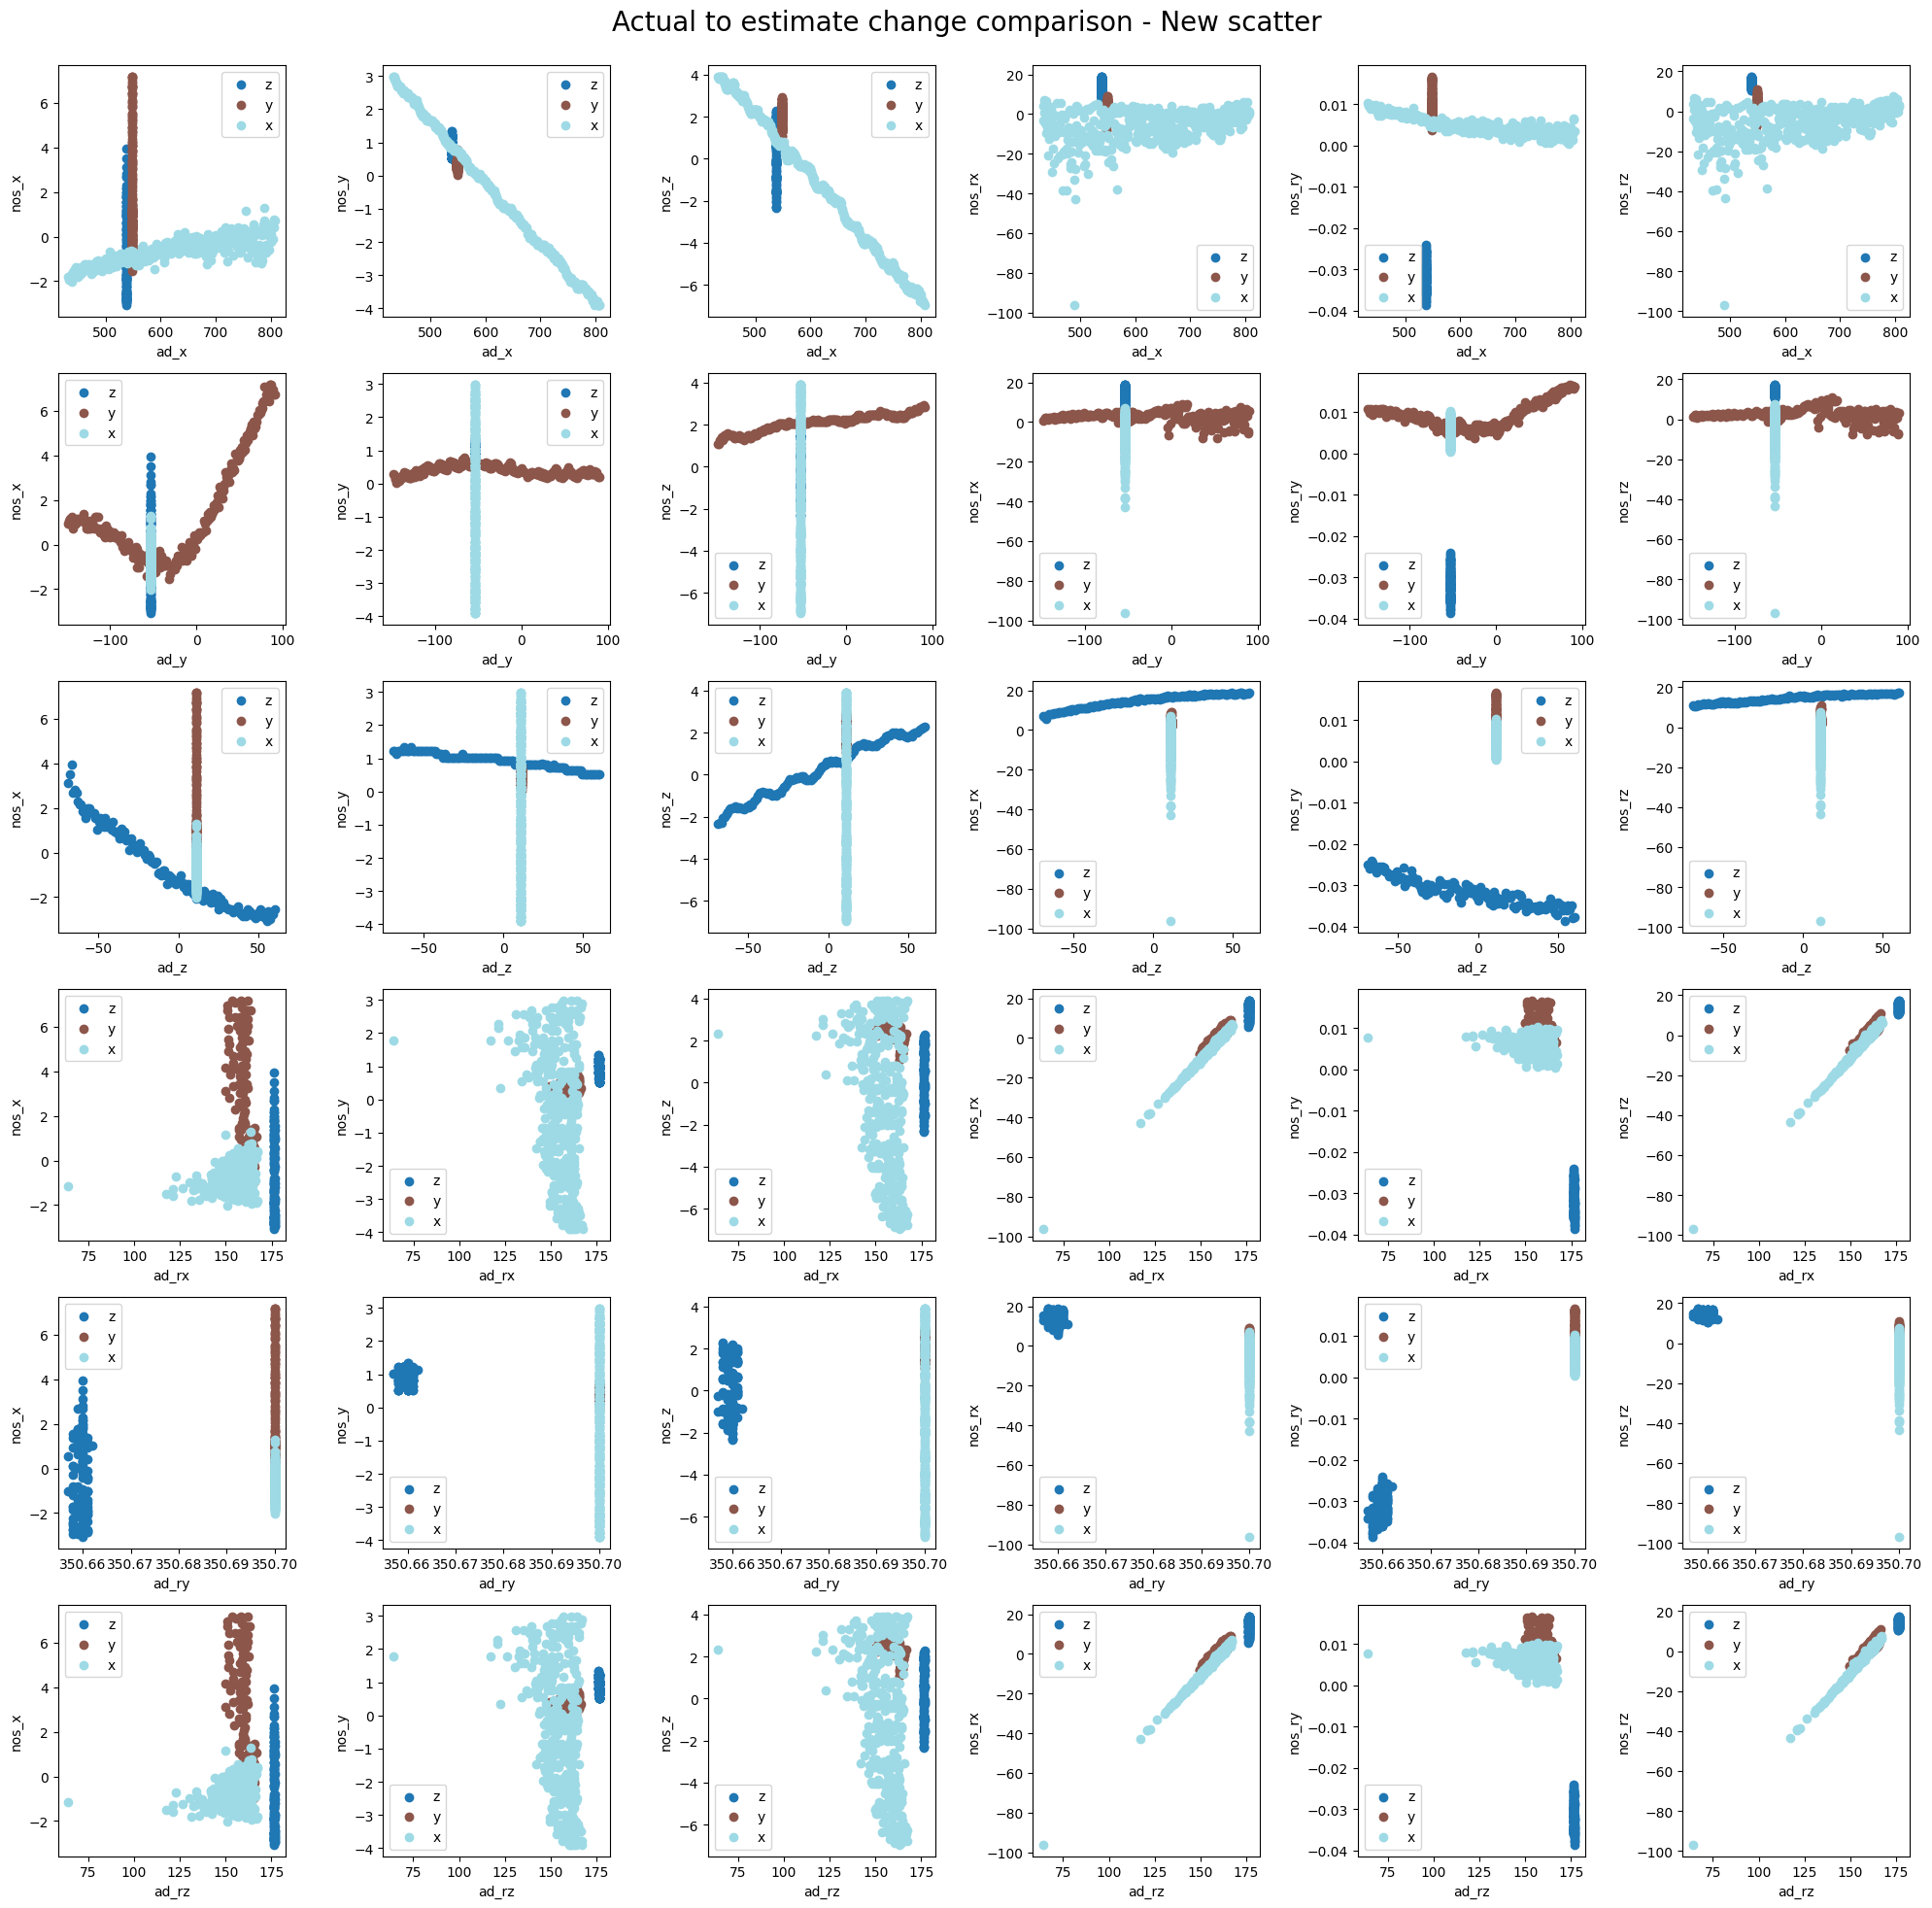

In [213]:
new_names = ["origin"]+ad_names+nos_names
show_scatter(result_df.loc[:,new_names],"New scatter",ad_names,nos_names)

In [214]:
#statistics of newly calculated offset
result_df.loc[:,nos_names].describe()

,nos_x,nos_y,nos_z,nos_rx,nos_ry,nos_rz
count,7.460000e+02,7.460000e+02,7.460000e+02,7.460000e+02,7.460000e+02,7.460000e+02
mean,1.901969e-12,1.650155e-14,-3.886078e-15,9.924739e-14,-7.650240e-14,1.669490e-13
std,1.844514e+00,1.545506e+00,2.829476e+00,1.057264e+01,1.493173e-02,1.062419e+01
min,-3.062167e+00,-3.895642e+00,-6.961943e+00,-9.619445e+01,-3.864282e-02,-9.687652e+01
25%,-1.006319e+00,-7.366547e-01,-1.613348e+00,-5.339754e+00,2.944642e-03,-5.468393e+00
50%,-4.611258e-01,3.984629e-01,1.361958e+00,1.498821e+00,5.341313e-03,1.621083e+00
75%,4.340370e-01,8.485772e-01,2.156395e+00,4.470118e+00,7.973722e-03,4.395363e+00
max,7.172590e+00,2.978314e+00,3.901880e+00,1.875695e+01,1.663710e-02,1.725904e+01


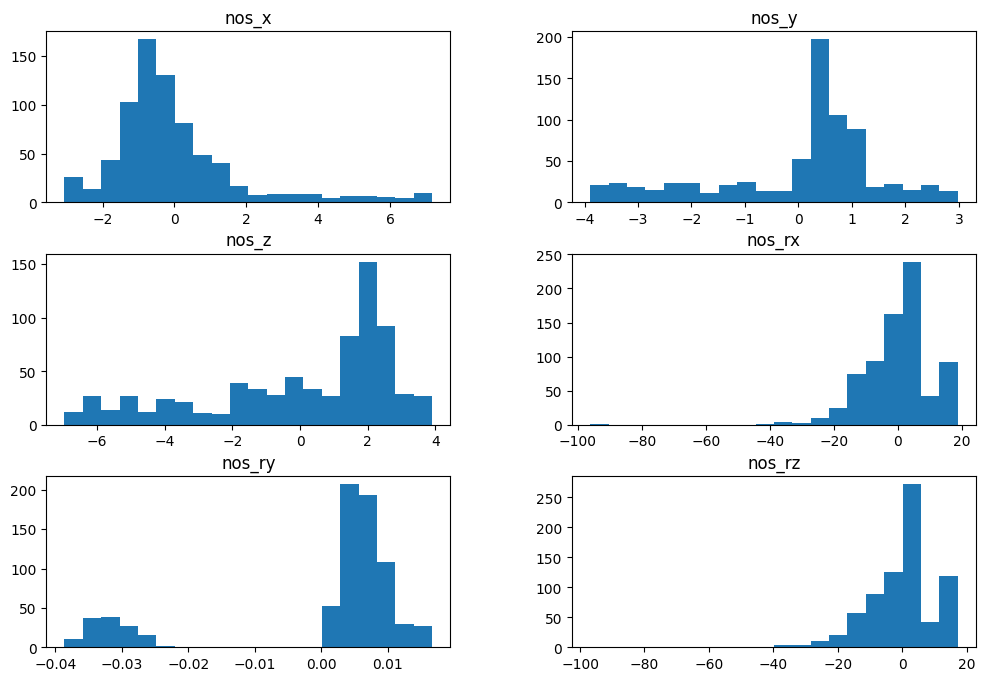

In [215]:
result_df.loc[:,nos_names].hist(figsize=[12,8],grid=False,bins=20)
plt.show()